In [1]:
import os
import sys
import importlib
# Add utilities to path (utilities is one directory down from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
import time
import fitz
import utilities.pdf_extraction_utils
import json
importlib.reload(utilities.pdf_extraction_utils)
from utilities.pdf_extraction_utils import (
    ExtractionConfig,
    load_pdf_page,
    analyze_layers,
    extract_polygons_from_layer,
    batch_extract_polygons,
    visualize_extraction_results,
    save_polygons_to_json,
    load_polygons_from_json,
    build_clip_map,
    filter_layer_paths,
    extract_lines_from_paths,
    cluster_and_snap_endpoints,
    extend_dangles,
    polygonize_lines,
    plot_polygons_on_pdf,
    get_buffered_polygon_bounds,
    draw_polygon_on_page,
    clip_pdf_to_polygon,
    get_label_from_gemini,
    get_page_label_from_gemini,
    process_elements_on_page,
    build_layout_geojson,
    extract_page_elements

)

c:\Users\roba7\Documents\Programming projects\as-built-processing\pdf_layout_extraction_dev\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


allign full site panels -> inverter poly -> combiner centroid guess -> panel allignment

In [2]:
from shapely.geometry import MultiLineString
from shapely.affinity import affine_transform
import numpy as np

from shapely.geometry import MultiLineString

def align_multilinestrings_by_convex_hull(source_mls, target_mls, scale_mode='area'):
    """
    Calculate affine transform (isotropic scale + translation) to align source_mls to target_mls
    based on their convex hulls. Returns (affine_params, transformed_source_mls).

    scale_mode: 'area' (default) - scale by area (sqrt of area ratio)
                'fit' - scale by max width/height, maintaining aspect ratio, so that the transformed
                        source fits entirely inside the target, centered on the target centroid
    """
    # Compute convex hulls
    source_hull = source_mls.convex_hull
    target_hull = target_mls.convex_hull

    # Centroids
    source_centroid = source_hull.centroid
    target_centroid = target_hull.centroid

    if scale_mode == 'area':
        # Areas
        source_area = source_hull.area
        target_area = target_hull.area

        # Isotropic scale to match areas
        scale = np.sqrt(target_area / source_area) if source_area > 0 else 1.0

        # Translation to align centroids after scaling
        dx = target_centroid.x - (source_centroid.x * scale)
        dy = target_centroid.y - (source_centroid.y * scale)

    elif scale_mode == 'fit':
        # Get bounds: (minx, miny, maxx, maxy)
        s_minx, s_miny, s_maxx, s_maxy = source_hull.bounds
        t_minx, t_miny, t_maxx, t_maxy = target_hull.bounds

        s_width = s_maxx - s_minx
        s_height = s_maxy - s_miny
        t_width = t_maxx - t_minx
        t_height = t_maxy - t_miny

        # Avoid division by zero
        if s_width == 0 or s_height == 0:
            scale = 1.0
        else:
            scale_x = t_width / s_width
            scale_y = t_height / s_height
            scale = min(scale_x, scale_y)

        # After scaling, align source so that the center of its bounding box matches the center of the target's bounding box
        s_center_x = (s_minx + s_maxx) / 2
        s_center_y = (s_miny + s_maxy) / 2
        t_center_x = (t_minx + t_maxx) / 2
        t_center_y = (t_miny + t_maxy) / 2

        scaled_source_center_x = s_center_x * scale
        scaled_source_center_y = s_center_y * scale

        dx = t_center_x - scaled_source_center_x
        dy = t_center_y - scaled_source_center_y

    else:
        raise ValueError("scale_mode must be 'area' or 'fit'")

    # Affine params: [a, b, d, e, xoff, yoff]
    affine_params = [scale, 0, 0, scale, dx, dy]
    transformed_source = affine_transform(source_mls, affine_params)

    return affine_params, transformed_source

In [3]:
test_pdf = "C:/Users/roba7/Documents/Programming projects/as-built-processing/pdf_layout_extraction_dev/docs/full_pdf/NorthStar As Built - Rev 2 2016-11-15.pdf"
page_number = 1

page, drawings = load_pdf_page(test_pdf, page_number)
layer_name = "Xpanels - Northstar|M-PLAN-TRACKER OUTLINE"
layer_paths = filter_layer_paths(drawings, layer_name)
config = ExtractionConfig()
lines = extract_lines_from_paths(layer_paths,config)


In [4]:
from shapely.ops import polygonize
from shapely.geometry import MultiLineString
polygons = list(polygonize(lines))
import shapely
# Create a MultiLineString from the lines
mls = MultiLineString([list(line.coords) for line in lines])

# Compute the convex hull of all the lines
convex_hull_poly = mls.convex_hull


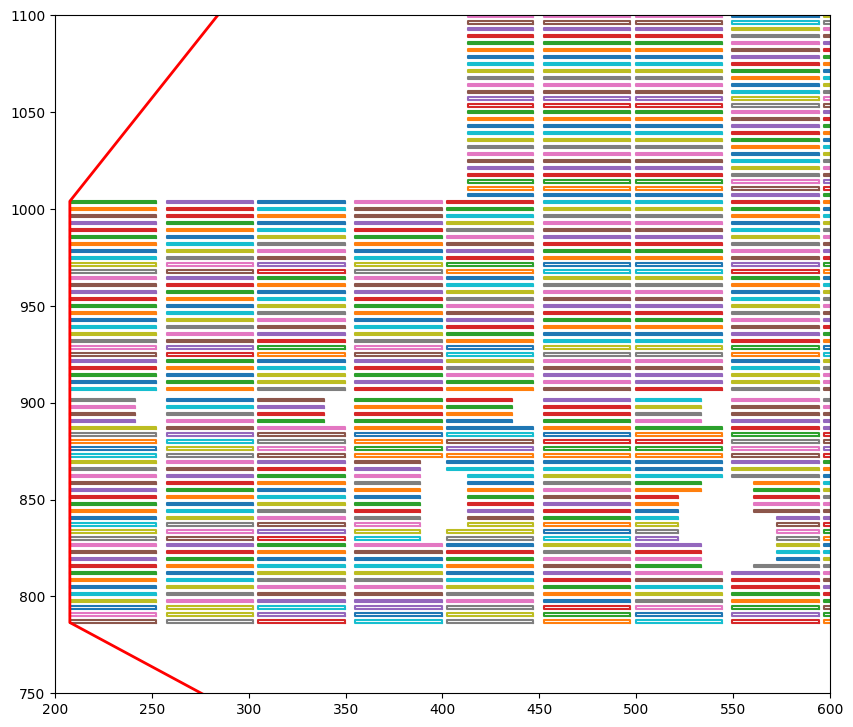

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
all_x = []
all_y = []
for poly in polygons:
    x, y = poly.exterior.xy
    ax.plot(x, y)
    all_x.extend(x)
    all_y.extend(y)


# Plot convex hull
hull_x, hull_y = convex_hull_poly.exterior.xy
ax.plot(hull_x, hull_y, color='red', linewidth=2, label='Convex Hull')

min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)
width = max_x - min_x
height = max_y - min_y
# Zoom to the bottom quarter
ax.set_xlim(200, 600)
ax.set_ylim(750, 1100)
ax.set_aspect('equal')
if 'hull' in locals():
    ax.legend()
plt.show()

In [ ]:
#do the same for inverter block outlines 

#extract inverter block outlines
file_path = "C:/Users/roba7/Documents/Programming projects/as-built-processing/pdf_layout_extraction_dev/docs/full_pdf/NorthStar As Built - Rev 2 2016-11-15.pdf"
config = ExtractionConfig()
layer_name = "key plan|BEI-BLOCK-OUTLINE"
page_number = 15
config.extension_length = 20
element_type = "inverter"
output_dir = None
inverter_result = extract_polygons_from_layer(file_path, page_number, layer_name, config)
inverter_label_poly_dict, token_total = process_elements_on_page(file_path, page_number, inverter_result['polygons'], element_type,output_dir)




In [17]:
import pickle

with open("layout_extended_13_63_running_record.pkl", "rb") as f:
    doc_json = pickle.load(f)

In [29]:
inverter_label_poly_dict

{' 2.3': <POLYGON ((1612 217, 1612 198.9, 1579.4 198.9, 1563.6 199, 1563.6 217, 1563....>,
 ' 2.2': <POLYGON ((1612 253.1, 1596.8 253.1, 1578.8 253.1, 1563.6 253.1, 1563.6 271....>,
 ' 5.2': <POLYGON ((1778.8 481.1, 1811.2 481.1, 1811.2 455.2, 1811.2 437.2, 1811.2 41...>,
 ' 5.3': <POLYGON ((1811.2 411.4, 1811.2 437.2, 1811.2 455.2, 1811.2 481.1, 1843.8 48...>,
 ' 2.1': <POLYGON ((1572.7 332.3, 1539.9 332.3, 1539.9 342.8, 1539.9 360.8, 1539.9 37...>,
 ' 2.4': <POLYGON ((1572.7 396.8, 1572.7 407.2, 1605.1 407.2, 1605.1 396.8, 1605.1 37...>,
 ' 2.5': <POLYGON ((1605.1 396.8, 1605.1 407.2, 1621.6 407.2, 1637.5 407.2, 1637.5 39...>,
 ' 2.6': <POLYGON ((1637.5 407.2, 1621.6 407.2, 1621.6 416.9, 1621.6 434.9, 1621.6 44...>,
 ' 2.8': <POLYGON ((1637.5 396.8, 1637.5 407.2, 1670 407.2, 1670 396.8, 1670 378.8, 1...>,
 ' 2.9': <POLYGON ((1670 396.8, 1670 407.2, 1686.3 407.2, 1702.8 407.2, 1702.8 396.8,...>,
 ' 2.7': <POLYGON ((1702.8 407.2, 1686.3 407.2, 1686.3 416.9, 1686.3 434.9, 1686.3 44...>,

In [30]:
doc_json[page_number]['page_label']

'2.2'

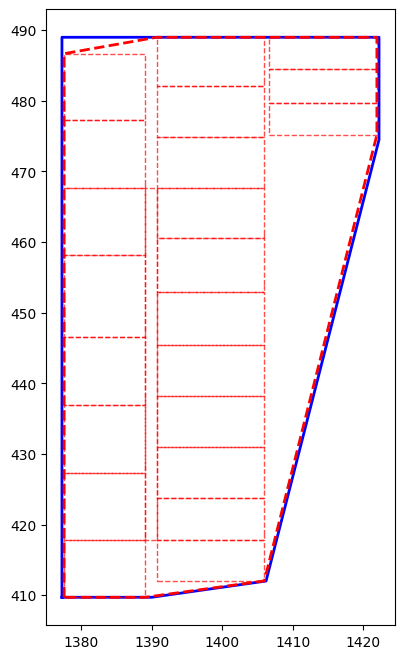

In [43]:
page_number = 14
combiners = doc_json[page_number]['page_elements']['combiner_outlines']
inverter_outline = inverter_label_poly_dict[' ' + doc_json[page_number]['page_label'].strip()]
mls_inverter = MultiLineString([list(inverter_outline.exterior.coords)])



mls_combiners = MultiLineString([list(poly.exterior.coords) for poly in combiners])
hull_combiners = mls_combiners.convex_hull


affine_params_combiner_to_inverter, transformed_source_combiner_outlines = align_multilinestrings_by_convex_hull(mls_combiners, mls_inverter,scale_mode='fit')

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot convex hull of target MultiLineString (mls)
mls_hull = mls_inverter.convex_hull
x, y = mls_hull.exterior.xy
ax.plot(x, y, color='blue', linewidth=2, label='Target Convex Hull')

# Plot convex hull of transformed source MultiLineString
transformed_hull = transformed_source_combiner_outlines.convex_hull
x2, y2 = transformed_hull.exterior.xy
ax.plot(x2, y2, color='red', linewidth=2, linestyle='--', label='Transformed Source Convex Hull')

# Plot transformed source MultiLineString
for line in transformed_source_combiner_outlines.geoms:
    x, y = line.xy
    ax.plot(x, y, color='red', linewidth=1, alpha=0.7, linestyle='--')

ax.set_aspect('equal')





In [44]:

# Compose the two affine transforms: combiner->inverter, then inverter->site
def compose_affine(a, b):
    # a, b: [a, b, d, e, xoff, yoff]
    # Returns parameters for affine_transform(geom, composed)
    a1, b1, d1, e1, xoff1, yoff1 = a
    a2, b2, d2, e2, xoff2, yoff2 = b
    return [
        a1 * a2 + b1 * d2,
        a1 * b2 + b1 * e2,
        d1 * a2 + e1 * d2,
        d1 * b2 + e1 * e2,
        xoff1 * a2 + yoff1 * d2 + xoff2,
        xoff1 * b2 + yoff1 * e2 + yoff2,
    ]

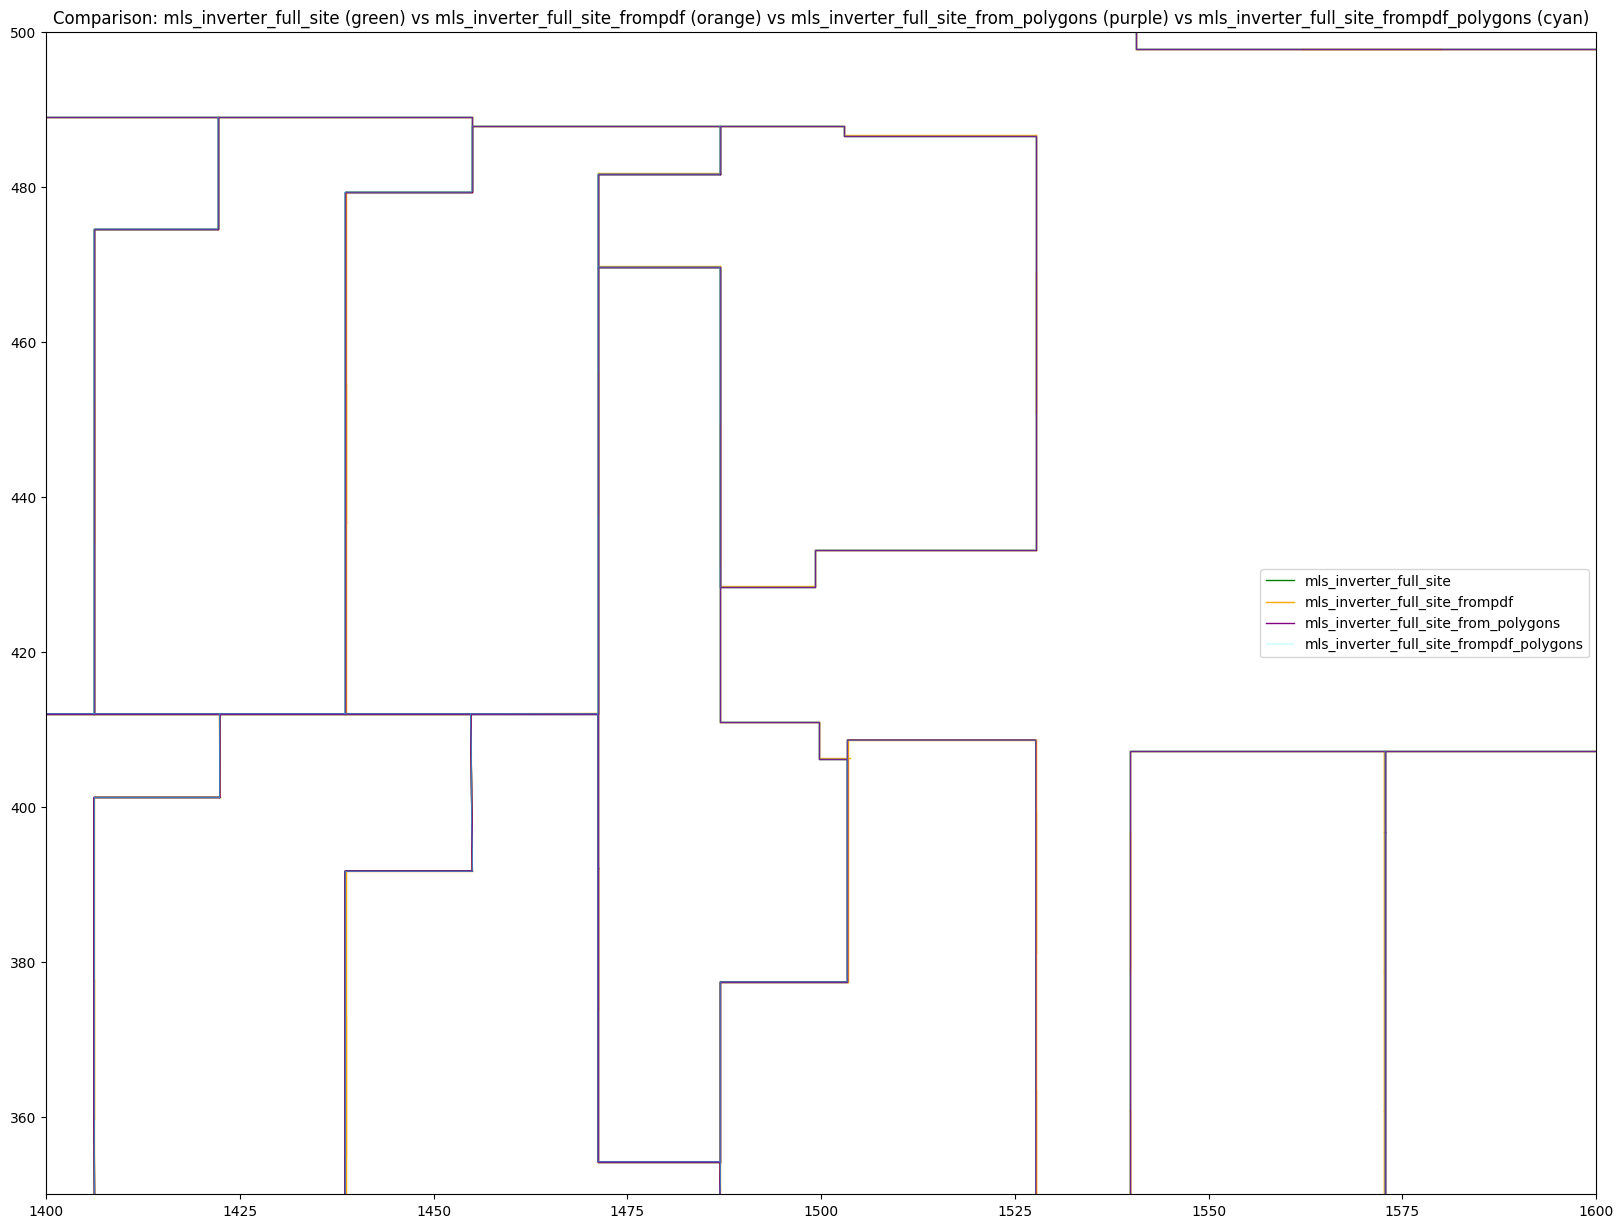

In [45]:
mls_inverter_full_site = MultiLineString([list(poly.exterior.coords) for poly in inverter_label_poly_dict.values()])

mls_inverter_full_site_frompdf = MultiLineString(
    [list(line.coords) for line in inverter_result['lines']] +
    [list(line.coords) for line in inverter_result['extensions']]
)

mls_inverter_full_site_from_polygons = MultiLineString([list(poly.exterior.coords) for poly in inverter_result['polygons']])

# re-do polygonize
union = shapely.union_all(mls_inverter_full_site_frompdf, grid_size=0.1)
mls_inverter_full_site_frompdf_polygons = list(polygonize(union))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))

# Plot mls_inverter_full_site in green
for line in mls_inverter_full_site.geoms if hasattr(mls_inverter_full_site, 'geoms') else [mls_inverter_full_site]:
    x, y = line.xy
    ax.plot(x, y, color='green', linewidth=1, label='mls_inverter_full_site')

# Plot mls_inverter_full_site_frompdf in orange
for line in mls_inverter_full_site_frompdf.geoms if hasattr(mls_inverter_full_site_frompdf, 'geoms') else [mls_inverter_full_site_frompdf]:
    x, y = line.xy
    ax.plot(x, y, color='orange', linewidth=1, label='mls_inverter_full_site_frompdf')

# Plot mls_inverter_full_site_from_polygons in purple
for line in mls_inverter_full_site_from_polygons.geoms if hasattr(mls_inverter_full_site_from_polygons, 'geoms') else [mls_inverter_full_site_from_polygons]:
    x, y = line.xy
    ax.plot(x, y, color='purple', linewidth=1, label='mls_inverter_full_site_from_polygons')

# Plot mls_inverter_full_site_frompdf_polygons in cyan (as polygons)
for poly in mls_inverter_full_site_frompdf_polygons:
    if hasattr(poly, "exterior"):
        x, y = poly.exterior.xy
        ax.plot(x, y, color='cyan', linewidth=0.2, label='mls_inverter_full_site_frompdf_polygons')

# Add legend (avoid duplicate labels)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())
ax.set_xlim(1400, 1600)
ax.set_ylim(350, 500)

ax.set_aspect('equal')
plt.title("Comparison: mls_inverter_full_site (green) vs mls_inverter_full_site_frompdf (orange) vs mls_inverter_full_site_from_polygons (purple) vs mls_inverter_full_site_frompdf_polygons (cyan)")
plt.show()


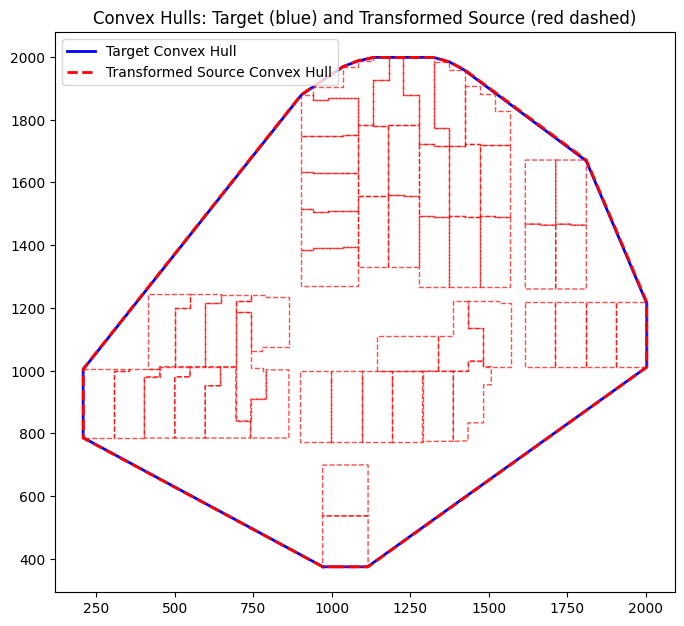

In [46]:
mls_inverter_full_site = MultiLineString([list(poly.exterior.coords) for poly in inverter_label_poly_dict.values()])

mls_inverter_full_site_frompdf = mls_inverter = MultiLineString(
    [list(line.coords) for line in inverter_result['lines']] +
    [list(line.coords) for line in inverter_result['extensions']]
)
    
affine_params_inverter_to_site, transformed_source = align_multilinestrings_by_convex_hull(mls_inverter_full_site, mls, scale_mode='fit')



import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot convex hull of target MultiLineString (mls)
mls_hull = mls.convex_hull
x, y = mls_hull.exterior.xy
ax.plot(x, y, color='blue', linewidth=2, label='Target Convex Hull')

# Plot convex hull of transformed source MultiLineString
transformed_hull = transformed_source.convex_hull
x2, y2 = transformed_hull.exterior.xy
ax.plot(x2, y2, color='red', linewidth=2, linestyle='--', label='Transformed Source Convex Hull')

# Plot transformed source MultiLineString
for line in transformed_source.geoms:
    x, y = line.xy
    ax.plot(x, y, color='red', linewidth=1, alpha=0.7, linestyle='--')


ax.set_aspect('equal')
ax.legend()
plt.title("Convex Hulls: Target (blue) and Transformed Source (red dashed)")
plt.show()


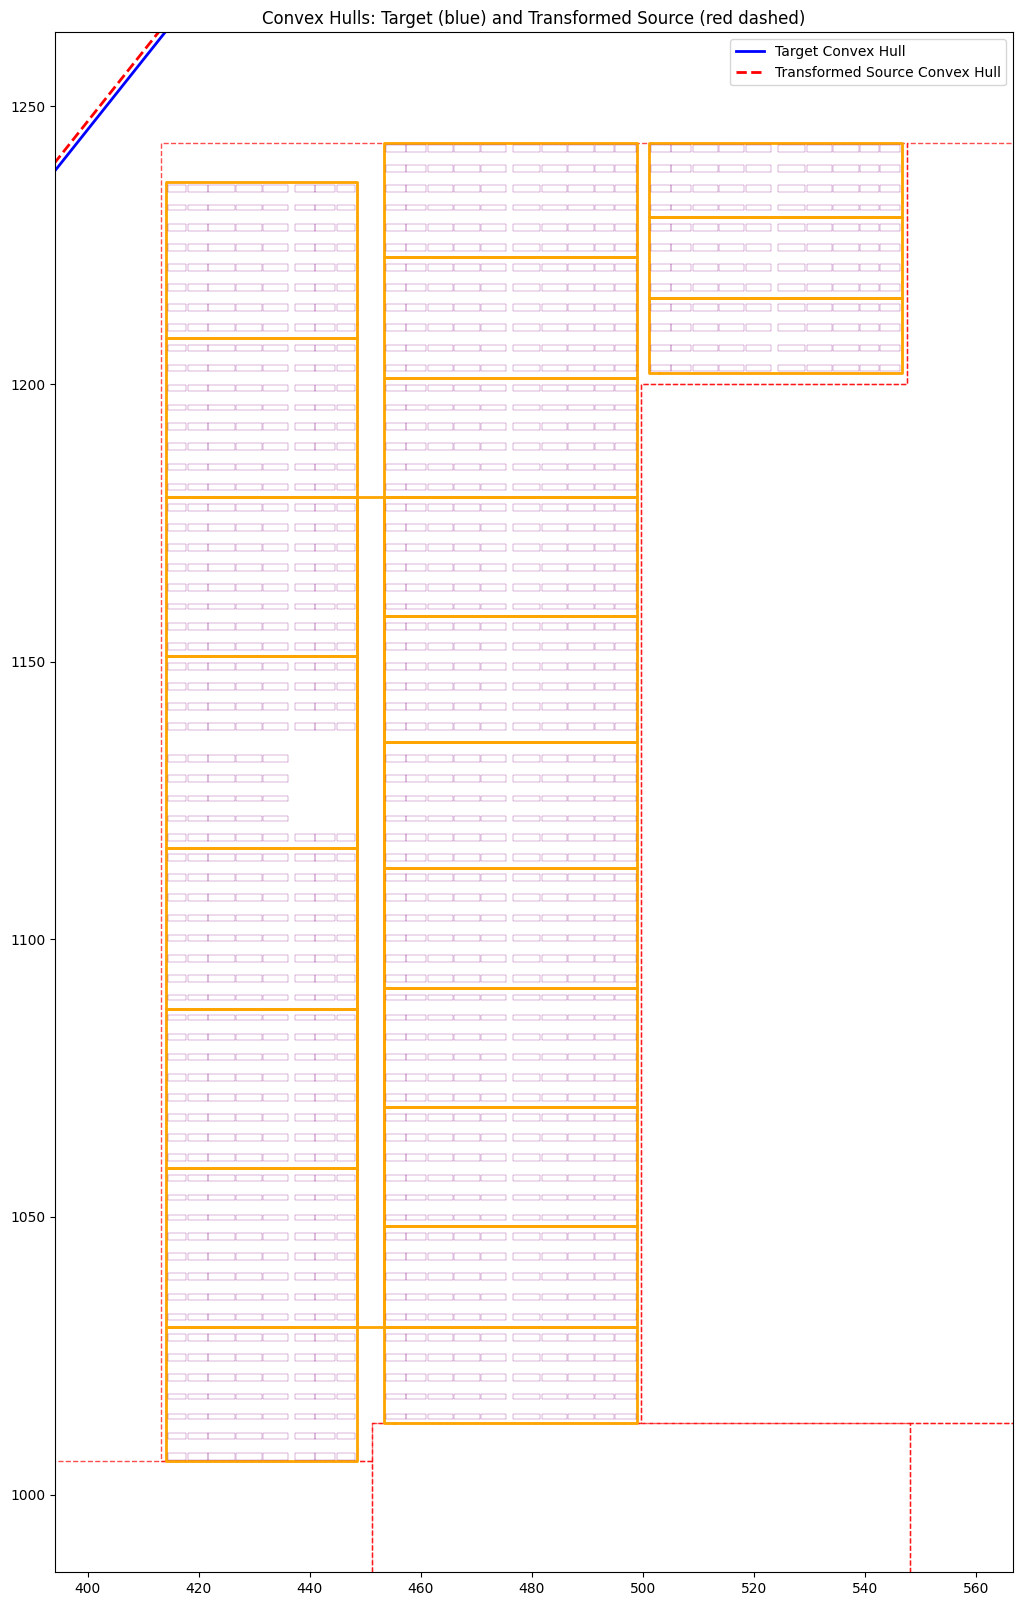

In [47]:

mls_inverter_full_site = MultiLineString([list(poly.exterior.coords) for poly in inverter_label_poly_dict.values()])
    
affine_params_inverter_to_site, transformed_source = align_multilinestrings_by_convex_hull(mls_inverter_full_site, mls, scale_mode='fit')

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))

# Plot convex hull of target MultiLineString (mls)
mls_hull = mls.convex_hull
x, y = mls_hull.exterior.xy
ax.plot(x, y, color='blue', linewidth=2, label='Target Convex Hull')

# Plot convex hull of transformed source MultiLineString
transformed_hull = transformed_source.convex_hull
x2, y2 = transformed_hull.exterior.xy
ax.plot(x2, y2, color='red', linewidth=2, linestyle='--', label='Transformed Source Convex Hull')

# Plot transformed source MultiLineString
for line in transformed_source.geoms:
    x, y = line.xy
    ax.plot(x, y, color='red', linewidth=1, alpha=0.7, linestyle='--')
from shapely.affinity import affine_transform

# Apply affine transform to transformed_source_combiner_outlines
transformed_source_combiner_outlines_site = affine_transform(transformed_source_combiner_outlines, affine_params_inverter_to_site)



# Plot transformed_source_combiner_outlines after affine transform
for line in transformed_source_combiner_outlines_site.geoms:
    x, y = line.xy
    ax.plot(x, y, color='green', linewidth=1, alpha=0.7, linestyle=':')


affine_params_combiner_to_site = compose_affine(affine_params_combiner_to_inverter, affine_params_inverter_to_site)
combiner_poly_site = affine_transform(mls_combiners, affine_params_combiner_to_site)

# Plot combiner_poly_site (MultiLineString)
for line in combiner_poly_site.geoms:
    x, y = line.xy
    ax.plot(x, y, color='orange', linewidth=2, linestyle='-')

rack_outlines = doc_json[page_number]['page_elements']['rack_outlines']
rack_outlines_transformed = [affine_transform(poly, affine_params_combiner_to_site) for poly in rack_outlines]

# Plot rack_outlines_transformed
for poly in rack_outlines_transformed:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='purple', linewidth=0.2, linestyle='-')

buffered = transformed_source_combiner_outlines_site.buffer(20)
minx, miny, maxx, maxy = buffered.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_aspect('equal')
ax.legend()
plt.title("Convex Hulls: Target (blue) and Transformed Source (red dashed)")
plt.show()









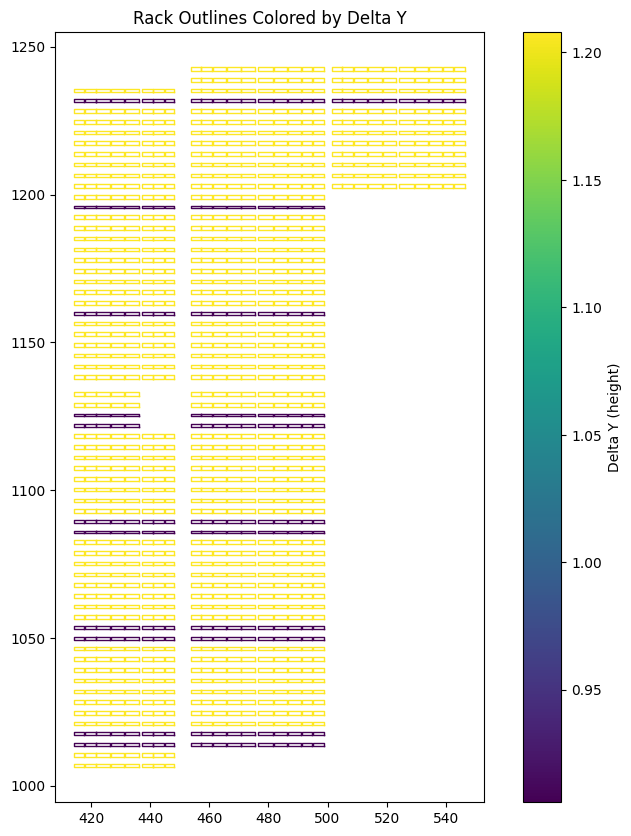

[0.9059394101643647,
 1.2079192135524863,
 1.2079192135526,
 1.2079192135527137,
 0.9059394101645921]

In [48]:
import matplotlib.pyplot as plt
import numpy as np

rack_outlines = doc_json[page_number]['page_elements']['rack_outlines']
rack_outlines = rack_outlines_transformed

# Compute delta y for each rack (max y - min y)
delta_ys = [poly.bounds[3] - poly.bounds[1] for poly in rack_outlines]
norm = plt.Normalize(min(delta_ys), max(delta_ys))
cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(10, 10))
for poly, dy in zip(rack_outlines, delta_ys):
    color = cmap(norm(dy))
    x, y = poly.exterior.xy
    ax.plot(x, y, color=color, linewidth=1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Delta Y (height)')
ax.set_aspect('equal')
plt.title("Rack Outlines Colored by Delta Y")
plt.show()
list(set(delta_ys))

In [49]:
type(combiner_poly_site)

shapely.geometry.multilinestring.MultiLineString

target width, source width 1.199951171875 1.2079192135524863
scale 0.9934034978597184
target pitch, source pitch, selected pitch 4.0 4.0 4.0
k -3
overlap 129
k -2
overlap 134
k -1
overlap 136
k 0
overlap 140
k 1
overlap 137
k 2
overlap 134
k 3
overlap 134
best_overlap 140
best_k 0


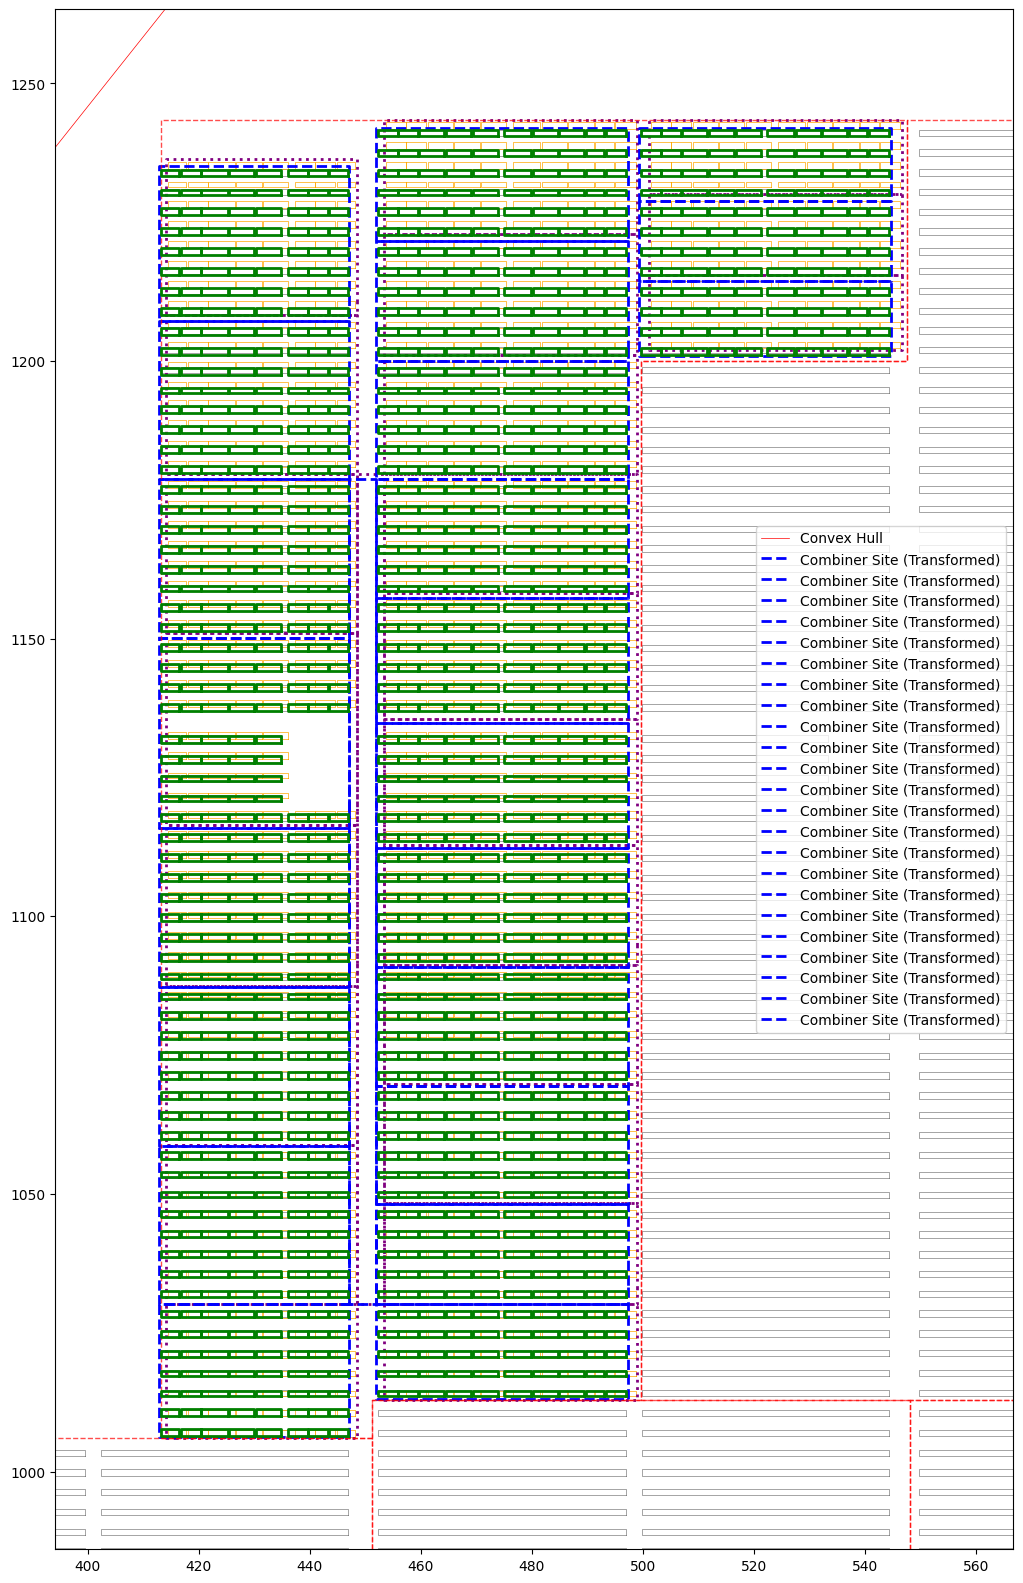

In [51]:
import matplotlib.pyplot as plt

import importlib, align_racking_v2
importlib.reload(align_racking_v2)



params, out_mls, aoi = align_racking_v2.align_by_width_edge_rows(combiner_poly_site, polygons, rack_outlines_transformed, row_shift_range=3)

fine_tune_affine = params['affine']

fig, ax = plt.subplots(figsize=(20, 20))
all_x = []
all_y = []

# Plot polygons
for poly in polygons:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='grey', linewidth=0.5)
    all_x.extend(x)
    all_y.extend(y)

# Plot rack_outlines_transformed
for poly in rack_outlines_transformed:
    x, y = poly.exterior.xy
    ax.plot(x, y, color='orange', linewidth=0.5)

# Plot convex hull
hull_x, hull_y = convex_hull_poly.exterior.xy
ax.plot(hull_x, hull_y, color='red', linewidth=0.5, label='Convex Hull')

# Plot combiner_poly_site (MultiLineString)
for line in combiner_poly_site.geoms:
    x, y = line.xy
    ax.plot(x, y, color='purple', linewidth=2, linestyle=':')

from shapely import affinity

# Apply fine_tune_affine to combiner_poly_site
combiner_poly_site_transformed = affinity.affine_transform(combiner_poly_site, fine_tune_affine)

# Plot transformed combiner_poly_site
for line in combiner_poly_site_transformed.geoms:
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=2, linestyle='--', label='Combiner Site (Transformed)')


# Plot transformed source MultiLineString
for line in transformed_source.geoms:
    x, y = line.xy
    ax.plot(x, y, color='red', linewidth=1, alpha=0.7, linestyle='--')

# Plot out_mls
if out_mls.geom_type == 'MultiLineString':
    for line in out_mls.geoms:
        x, y = line.xy
        ax.plot(x, y, color='green', linewidth=2, linestyle='-')
elif out_mls.geom_type == 'LineString':
    x, y = out_mls.xy
    ax.plot(x, y, color='green', linewidth=2, linestyle='-')

min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)
width = max_x - min_x
height = max_y - min_y
# Set xlim, ylim to combiner_poly_site bounds plus 20 buffer
minx, miny, maxx, maxy = combiner_poly_site.bounds
ax.set_xlim(minx - 20, maxx + 20)
ax.set_ylim(miny - 20, maxy + 20)
ax.set_aspect('equal')
ax.legend()
plt.show()

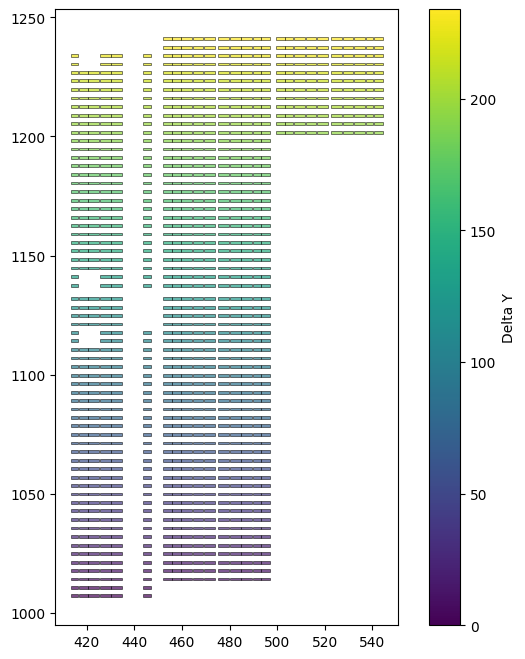

In [52]:
from shapely.ops import polygonize
import matplotlib.pyplot as plt
import numpy as np

# Polygonize out_mls to get polygons
polys = list(polygonize(out_mls))

# Compute centroid y for each polygon
centroid_ys = np.array([p.centroid.y for p in polys])
delta_ys = centroid_ys - np.min(centroid_ys)

# Normalize delta_ys for colormap
norm = plt.Normalize(vmin=np.min(delta_ys), vmax=np.max(delta_ys))
cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(8, 8))
for poly, dy in zip(polys, delta_ys):
    color = cmap(norm(dy))
    x, y = poly.exterior.xy
    ax.fill(x, y, color=color, alpha=0.7, edgecolor='k', linewidth=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Delta Y')
ax.set_aspect('equal')
plt.show()

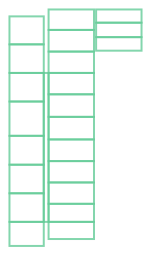

In [15]:
combiner_poly_site

In [38]:
polygons

[<POLYGON ((1373.84 1274.92, 1329.2 1274.92, 1329.2 1276.12, 1373.84 1276.12,...>,
 <POLYGON ((1373.84 1278.64, 1329.2 1278.64, 1329.2 1279.72, 1373.84 1279.72,...>,
 <POLYGON ((1373.84 1282.24, 1329.2 1282.24, 1329.2 1283.32, 1373.84 1283.32,...>,
 <POLYGON ((1373.84 1285.84, 1329.2 1285.84, 1329.2 1287.04, 1373.84 1287.04,...>,
 <POLYGON ((1373.84 1289.44, 1329.2 1289.44, 1329.2 1290.64, 1373.84 1290.64,...>,
 <POLYGON ((1373.84 1293.16, 1329.2 1293.16, 1329.2 1294.24, 1373.84 1294.24,...>,
 <POLYGON ((1373.84 1296.76, 1329.2 1296.76, 1329.2 1297.84, 1373.84 1297.84,...>,
 <POLYGON ((1373.84 1300.36, 1329.2 1300.36, 1329.2 1301.56, 1373.84 1301.56,...>,
 <POLYGON ((1373.84 1303.96, 1329.2 1303.96, 1329.2 1305.16, 1373.84 1305.16,...>,
 <POLYGON ((1373.84 1307.68, 1329.2 1307.68, 1329.2 1308.76, 1373.84 1308.76,...>,
 <POLYGON ((1373.84 1311.28, 1329.2 1311.28, 1329.2 1312.36, 1373.84 1312.36,...>,
 <POLYGON ((1373.84 1314.88, 1329.2 1314.88, 1329.2 1316.08, 1373.84 1316.08,...>,
 <PO

In [40]:
rack_outlines

[<POLYGON ((837 327, 792 327, 792 336, 837 336, 837 327))>,
 <POLYGON ((789 327, 744 327, 744 336, 789 336, 789 327))>,
 <POLYGON ((741 327, 696 327, 696 336, 741 336, 741 327))>,
 <POLYGON ((897 327, 849 327, 849 336, 897 336, 897 327))>,
 <POLYGON ((945 327, 900 327, 900 336, 945 336, 945 327))>,
 <POLYGON ((993 327, 948 327, 948 336, 993 336, 993 327))>,
 <POLYGON ((1029 327, 996 327, 996 336, 1029 336, 1029 327))>,
 <POLYGON ((1068 327, 1032 327, 1032 336, 1068 336, 1068 327))>,
 <POLYGON ((693 327, 657 327, 657 336, 693 336, 693 327))>,
 <POLYGON ((657 336, 657 327, 621 327, 621 336, 657 336))>,
 <POLYGON ((837 363, 792 363, 792 372, 837 372, 837 363))>,
 <POLYGON ((789 363, 744 363, 744 372, 789 372, 789 363))>,
 <POLYGON ((741 363, 696 363, 696 372, 741 372, 741 363))>,
 <POLYGON ((897 363, 849 363, 849 372, 897 372, 897 363))>,
 <POLYGON ((945 363, 900 363, 900 372, 945 372, 945 363))>,
 <POLYGON ((993 363, 948 363, 948 372, 993 372, 993 363))>,
 <POLYGON ((1029 363, 996 363, 9

In [39]:
rack_outlines_transformed

[<POLYGON ((475.42 1013.544, 470.891 1013.544, 470.891 1014.45, 475.42 1014.4...>,
 <POLYGON ((470.589 1013.544, 466.059 1013.544, 466.059 1014.45, 470.589 1014...>,
 <POLYGON ((465.757 1013.544, 461.227 1013.544, 461.227 1014.45, 465.757 1014...>,
 <POLYGON ((481.46 1013.544, 476.628 1013.544, 476.628 1014.45, 481.46 1014.4...>,
 <POLYGON ((486.292 1013.544, 481.762 1013.544, 481.762 1014.45, 486.292 1014...>,
 <POLYGON ((491.123 1013.544, 486.594 1013.544, 486.594 1014.45, 491.123 1014...>,
 <POLYGON ((494.747 1013.544, 491.425 1013.544, 491.425 1014.45, 494.747 1014...>,
 <POLYGON ((498.673 1013.544, 495.049 1013.544, 495.049 1014.45, 498.673 1014...>,
 <POLYGON ((460.925 1013.544, 457.302 1013.544, 457.302 1014.45, 460.925 1014...>,
 <POLYGON ((457.302 1014.45, 457.302 1013.544, 453.678 1013.544, 453.678 1014...>,
 <POLYGON ((475.42 1017.168, 470.891 1017.168, 470.891 1018.073, 475.42 1018....>,
 <POLYGON ((470.589 1017.168, 466.059 1017.168, 466.059 1018.073, 470.589 101...>,
 <PO

In [35]:
print(affine_params_combiner_to_site)
print(affine_params_combiner_to_inverter)
print(affine_params_inverter_to_site)
print(fine_tune_affine)


[0.10065993446271204, 0.0, 0.0, 0.10065993446271204, 391.1680165888074, 980.6279757748223]
[0.03363019508057676, 0, 0, 0.03363019508057676, 1369.9368320610688, 401.2251908396947]
[2.993141556911412, 0, 0, 2.993141556911412, -3709.246845796748, -220.29581660717986]
[0.9934034978597184, 0.0, 0.0, 0.9934034978597184, 1.5532542456105034, 6.821878902913928]


In [ ]:
from shapely import affinity

# Create affine transform using params (scale, dx, dy)
affine_transformed = affinity.affine_transform(
    out_mls,
    
)
affine_transformed

{'scale': 0.9934034978597184,
 'dx': -1.5043489935712842,
 'dy': -0.6690675204000627,
 'pitch': 4.0,
 'row_shift': 0}

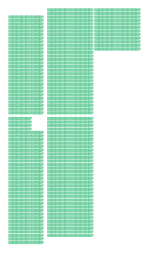

In [26]:
out_mls

In [61]:
from shapely.geometry import shape, MultiLineString, MultiPolygon
import json
from align_racking import align_racking_affine_lines, Options

opts = Options(
    aoi_buffer_in_row_pitch=1.5,
    neighbor_max_in_row_pitch=1.2,
    source_line_buffer_abs=None,     # use 0.15 * pitch automatically
    simplify_tolerance=0.02,         # speedup
    iters=4
)

# Convert rack_outlines_transformed (list of polygons) to MultiLineString
rack_outlines_mls = MultiLineString([list(poly.exterior.coords) for poly in rack_outlines_transformed])

params, source_lines_xformed, aoi_buffer = align_racking_affine_lines(
    combiner_poly_site, polygons, rack_outlines_mls, opts
)


KeyboardInterrupt: 

In [ ]:
from shapely.geometry import shape, MultiLineString, MultiPolygon
import json
from align_racking import align_racking_affine_lines, Options

opts = Options(
    aoi_buffer_in_row_pitch=1.5,
    neighbor_max_in_row_pitch=1.2,
    source_line_buffer_abs=None,     # use 0.15 * pitch automatically
    simplify_tolerance=0.02,         # speedup
    iters=4
)

# Convert rack_outlines_transformed (list of polygons) to MultiLineString
rack_outlines_mls = MultiLineString([list(poly.exterior.coords) for poly in rack_outlines_transformed])

params, source_lines_xformed, aoi_buffer = align_racking_affine_lines(
    combiner_poly_site, polygons, rack_outlines_mls, opts
)


KeyboardInterrupt: 

In [58]:
import json
from shapely.geometry import mapping

# Prepare GeoJSON FeatureCollection
features = []

# Add combiner_poly_site as a feature
features.append({
    "type": "Feature",
    "geometry": mapping(combiner_poly_site),
    "properties": {"role": "combiner_bounding_boxes"}
})

# Add polygons as features
for poly in polygons:
    features.append({
        "type": "Feature",
        "geometry": mapping(poly),
        "properties": {"role": "racking_polygons_target"}
    })

# Add rack_outlines as features
for poly in rack_outlines_transformed:
    features.append({
        "type": "Feature",
        "geometry": mapping(poly),
        "properties": {"role": "racking_outlines_source"}
    })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

with open("combiner_poly_site_polygons_rack_outlines_v2.geojson", "w") as f:
    json.dump(geojson_data, f)


In [ ]:
import json
from shapely.geometry import mapping

# Prepare GeoJSON FeatureCollection
features = []

# Add combiner_poly_site as a feature
features.append({
    "type": "Feature",
    "geometry": mapping(combiner_poly_site),
    "properties": {"role": "combiner_bounding_boxes"}
})

# Add polygons as features
for poly in polygons:
    features.append({
        "type": "Feature",
        "geometry": mapping(poly),
        "properties": {"role": "racking_polygons_target"}
    })

# Add rack_outlines as features
for poly in rack_outlines_transformed:
    features.append({
        "type": "Feature",
        "geometry": mapping(poly),
        "properties": {"role": "racking_outlines_source"}
    })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

with open("combiner_poly_site_polygons_rack_outlines_v2.geojson", "w") as f:
    json.dump(geojson_data, f)
